In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
train_path = 'cats-and-dogs/train'
valid_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size = 10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size = 4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size = 10)

Found 40 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(train_batches)

/Users/davescott/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


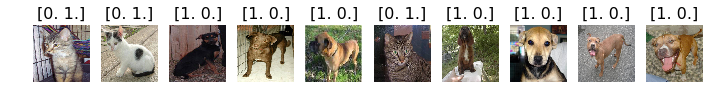

In [6]:
plots(imgs, titles=labels)

# Build and train CNN

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax')   
])

In [8]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                   validation_data=valid_batches, validation_steps=4,
                   epochs=5, verbose=2)

Epoch 1/5
 - 1s - loss: 7.7670 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


## Note, .fit_generator is for batch by batch fitting. .fit is for single batches.

## Accuracy and fit are very bad on the prior model.

# Predict

/Users/davescott/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


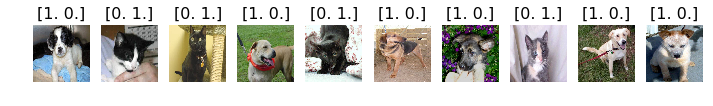

In [10]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [11]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 1., 0., 1., 1., 0., 1., 1.], dtype=float32)

In [12]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [13]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [14]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[4 0]
 [6 0]]


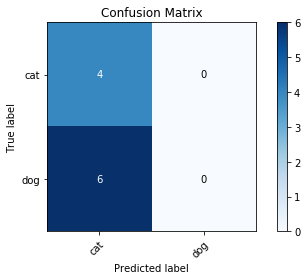

In [16]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# A simple model like this would never be able to predict properly for the difficult task.

# Build Fine-tuned VGG16 model

In [17]:
vgg16_model = keras.applications.vgg16.VGG16()

/Users/davescott/anaconda3/lib/python3.7/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [18]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
type(vgg16_model)

keras.engine.training.Model

## As these are different types of models, we will build the same as a Sequential model

In [20]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [22]:
for layer in model.layers:
    layer.trainable = False

In [23]:
model.add(Dense(2, activation='softmax'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Now by adding an additional layer of one that's output size two, we may create the properly sized output for our system

# Training and fine tuning

In [25]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4,
                   epochs=100, verbose=2)

Epoch 1/100
 - 13s - loss: 0.6869 - acc: 0.6750 - val_loss: 0.6881 - val_acc: 0.5714
Epoch 2/100
 - 13s - loss: 0.6866 - acc: 0.6750 - val_loss: 0.6879 - val_acc: 0.5714
Epoch 3/100
 - 13s - loss: 0.6864 - acc: 0.7000 - val_loss: 0.6877 - val_acc: 0.5714
Epoch 4/100
 - 13s - loss: 0.6861 - acc: 0.7000 - val_loss: 0.6874 - val_acc: 0.5714
Epoch 5/100
 - 13s - loss: 0.6859 - acc: 0.7000 - val_loss: 0.6872 - val_acc: 0.5714
Epoch 6/100
 - 13s - loss: 0.6857 - acc: 0.7000 - val_loss: 0.6870 - val_acc: 0.5714
Epoch 7/100
 - 13s - loss: 0.6854 - acc: 0.7000 - val_loss: 0.6868 - val_acc: 0.5714
Epoch 8/100
 - 13s - loss: 0.6852 - acc: 0.7000 - val_loss: 0.6865 - val_acc: 0.5714
Epoch 9/100
 - 13s - loss: 0.6849 - acc: 0.7000 - val_loss: 0.6863 - val_acc: 0.5714
Epoch 10/100
 - 13s - loss: 0.6847 - acc: 0.7000 - val_loss: 0.6861 - val_acc: 0.5714
Epoch 11/100
 - 14s - loss: 0.6845 - acc: 0.7000 - val_loss: 0.6858 - val_acc: 0.5714
Epoch 12/100
 - 13s - loss: 0.6842 - acc: 0.7000 - val_loss: 0.

Epoch 97/100
 - 14s - loss: 0.6641 - acc: 0.9000 - val_loss: 0.6661 - val_acc: 0.9286
Epoch 98/100
 - 14s - loss: 0.6639 - acc: 0.9000 - val_loss: 0.6659 - val_acc: 0.9286
Epoch 99/100
 - 14s - loss: 0.6637 - acc: 0.9000 - val_loss: 0.6657 - val_acc: 1.0000
Epoch 100/100
 - 14s - loss: 0.6634 - acc: 0.9000 - val_loss: 0.6654 - val_acc: 1.0000


# Predict and fine-tune the VGG16 Model

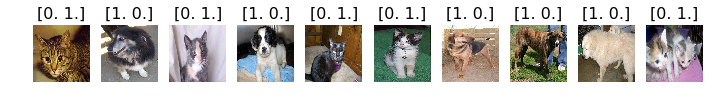

In [32]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [33]:
test_labels = test_labels[:,0]
test_labels

array([0., 1., 0., 1., 0., 0., 1., 1., 1., 0.], dtype=float32)

In [34]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [35]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[5 0]
 [1 4]]


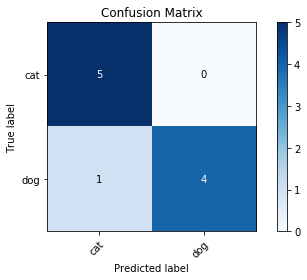

In [36]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Significantly better performance than the model beforehand.